In [3]:
from pomegranate import *
import matplotlib.pyplot as plot
import re

In [18]:
def path_to_alignment( x, y, path ):
    """
    This function will take in two sequences, and the ML path which is their alignment,
    and insert dashes appropriately to make them appear aligned. This consists only of
    adding a dash to the model sequence for every insert in the path appropriately, and
    a dash in the observed sequence for every delete in the path appropriately.
    """
    
    sl = None
    pl = None
    il = None
    
    a = []
    b = []
    
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name
        
        m = re.search('([MDIR]+)(\d+)', name)
        s = m.group(1)
        p = int(m.group(2))

        if s == 'RD':
            if sl == 'M' or sl == 'I' or sl == 'D':
                a.append(x[pl:(p-1)])
                b.append((p-pl-1)*'~')
        elif s == 'RI':
            if sl == 'M' or sl == 'I' or sl == 'D':
                a.append((p-pl-1)*'~')
                b.append(y[il:(i-1)])
        elif s == 'M' or s == 'I' or s == 'D':
            if sl == 'RI':
                a.append((p-pl-1)*'~')
                b.append(y[il:(i-1)])
            elif sl == 'RD':
                a.append(x[pl:(p-1)])
                b.append((p-pl-1)*'~')

            if s == 'M':
                a.append(x[p-1])
                b.append(y[i-1])
            elif s == 'I':
                a.append('-')
                b.append(y[i-1])
            elif s == 'D':
                a.append(x[p-1])
                b.append('-')
            
        sl = s
        pl = p
        il = i

    return ''.join(a), ''.join(b)

In [5]:
def make_global_alignment_model(target):
    model = HiddenMarkovModel()
    s = {}
    
    # add states
    i0 = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name="I0")
    model.add_state(i0)

    s[i0.name] = i0
    
    for c in range(len(target)):
        dc = State(None, name=f"D{c+1}")
        
        mc = State(DiscreteDistribution({
            "A": 0.94 if target[c] == 'A' else 0.02,
            "C": 0.94 if target[c] == 'C' else 0.02,
            "G": 0.94 if target[c] == 'G' else 0.02,
            "T": 0.94 if target[c] == 'T' else 0.02,
        }), name=f"M{c+1}")
        
        ic = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name=f"I{c+1}")

        model.add_states([mc, ic, dc])
        
        s[dc.name] = dc
        s[mc.name] = mc
        s[ic.name] = ic
        
    # add transitions
    model.add_transition(model.start, s['I0'], 0.05)
    model.add_transition(model.start, s['D1'], 0.05)
    model.add_transition(model.start, s['M1'], 0.90)
    
    model.add_transition(s['I0'], s['I0'], 0.70)
    model.add_transition(s['I0'], s['D1'], 0.15)
    model.add_transition(s['I0'], s['M1'], 0.15)
    
    for c in range(1, len(target)):
        model.add_transition(s[f'D{c}'], s[f'D{c+1}'], 0.15)
        model.add_transition(s[f'D{c}'], s[f'I{c}'],   0.70)
        model.add_transition(s[f'D{c}'], s[f'M{c+1}'], 0.15)
        
        model.add_transition(s[f'I{c}'], s[f'D{c+1}'], 0.15)
        model.add_transition(s[f'I{c}'], s[f'I{c}'],   0.15)
        model.add_transition(s[f'I{c}'], s[f'M{c+1}'], 0.70)

        model.add_transition(s[f'M{c}'], s[f'D{c+1}'], 0.05)
        model.add_transition(s[f'M{c}'], s[f'I{c}'],   0.05)
        model.add_transition(s[f'M{c}'], s[f'M{c+1}'], 0.90)
    
    model.add_transition(s[f'D{len(target)}'], s[f'I{len(target)}'], 0.70)
    model.add_transition(s[f'D{len(target)}'], model.end, 0.30)

    model.add_transition(s[f'I{len(target)}'], s[f'I{len(target)}'], 0.15)
    model.add_transition(s[f'I{len(target)}'], model.end, 0.85)

    model.add_transition(s[f'M{len(target)}'], s[f'I{len(target)}'], 0.90)
    model.add_transition(s[f'M{len(target)}'], model.end, 0.10)
    
    model.bake()
    
    return model

In [26]:
def make_random_model(suffix):
    model = HiddenMarkovModel()
    
    # add states
    ri = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name=f"RI{suffix}")
    rd = State(None, name=f"RD{suffix}")
    
    # add transitions
    model.add_transition(model.start, ri, 0.5)
    model.add_transition(model.start, rd, 0.5)
    
    model.add_transition(ri, ri, 0.5)
    model.add_transition(ri, rd, 0.5)
    
    model.add_transition(rd, model.end, 1.0)
    
    model.bake()
    
    return model

In [28]:
def plot(model):
    l = {}
    for s in model.states:
        l[s] = s.name

    model.plot(labels=l)

In [89]:
target = "CCAGATACGTACTTATCGATCGGGGATAC"

model_global = make_global_alignment_model(target)
model_random_left = make_random_model(0)
model_random_right = make_random_model(len(target)+1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Install pygraphviz for nicer visualizations
  


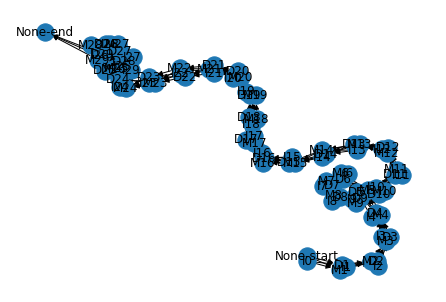

In [90]:
plot(model_global)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Install pygraphviz for nicer visualizations
  


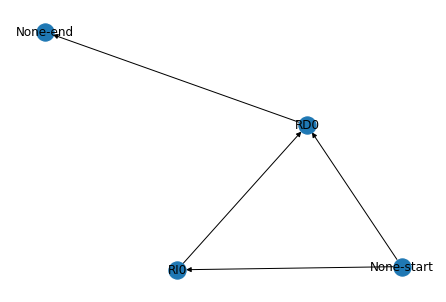

In [91]:
plot(model_random_left)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Install pygraphviz for nicer visualizations
  


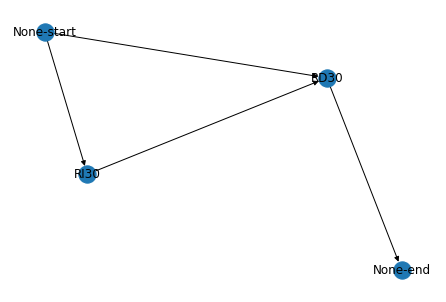

In [92]:
plot(model_random_right)

In [93]:
model_global.concatenate(model_random_right)
model_random_left.concatenate(model_global)
model = model_random_left

model.bake()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Install pygraphviz for nicer visualizations
  


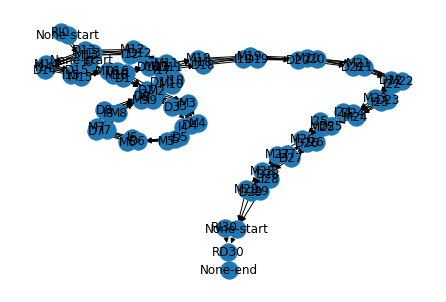

In [94]:
plot(model)

In [95]:
for sequence in map(list, ('CGTACTTATCGATCG', 'CTTATCG', 'CCAGATACGTACTTATCGATCGGGGATAC')):
    logp, path = model.viterbi(sequence)
    #x, y = path_to_alignment(target, ''.join(sequence), path)
    
    print(f"Sequence: {''.join(sequence)}, Log Probability: {logp}")
    #print(f"{x}\n{y}")
    print(" ".join( state.name for idx, state in path[1:-1] ))
    print("")

Sequence: CGTACTTATCGATCG, Log Probability: -35.64746979105113
None-start D1 D2 D3 D4 D5 D6 D7 M8 M9 M10 M11 M12 M13 M14 M15 M16 M17 M18 M19 M20 M21 M22 D23 D24 D25 D26 D27 D28 D29 None-start RD30

Sequence: CTTATCG, Log Probability: -49.4865423151309
None-start D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 D11 M12 M13 M14 M15 M16 M17 M18 D19 D20 D21 D22 D23 D24 D25 D26 D27 D28 D29 None-start RD30

Sequence: CCAGATACGTACTTATCGATCGGGGATAC, Log Probability: -8.538721116015438
None-start M1 M2 M3 M4 M5 M6 M7 M8 M9 M10 M11 M12 M13 M14 M15 M16 M17 M18 M19 M20 M21 M22 M23 M24 M25 M26 M27 M28 M29 None-start RD30

